In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/coin_Cardano1.csv")
df

,Date,High,Low,Open,Close,Volume,Marketcap
0,10/2/2017,0.030088,0.019969,0.024607,0.025932,5.764130e+07,6.288991e+08
1,10/3/2017,0.027425,0.020690,0.025757,0.020816,1.699780e+07,5.396927e+08
2,10/4/2017,0.022806,0.020864,0.020864,0.021931,9.000050e+06,5.686195e+08
3,10/5/2017,0.022154,0.020859,0.021951,0.021489,5.562510e+06,5.571390e+08
4,10/6/2017,0.021542,0.018360,0.021359,0.018539,7.780710e+06,4.806646e+08
...,...,...,...,...,...,...,...
1369,7/2/2021,1.394397,1.286607,1.332942,1.394397,2.159410e+09,4.454587e+10
1370,7/3/2021,1.441714,1.359664,1.394152,1.406836,2.028094e+09,4.494324e+10
1371,7/4/2021,1.493717,1.382153,1.404008,1.458184,1.806362e+09,4.658364e+10
1372,7/5/2021,1.461221,1.379284,1.461221,1.404898,1.759461e+09,4.488134e+10


In [ ]:
df.shape

(1374, 7)

Text(0, 0.5, 'High Price')

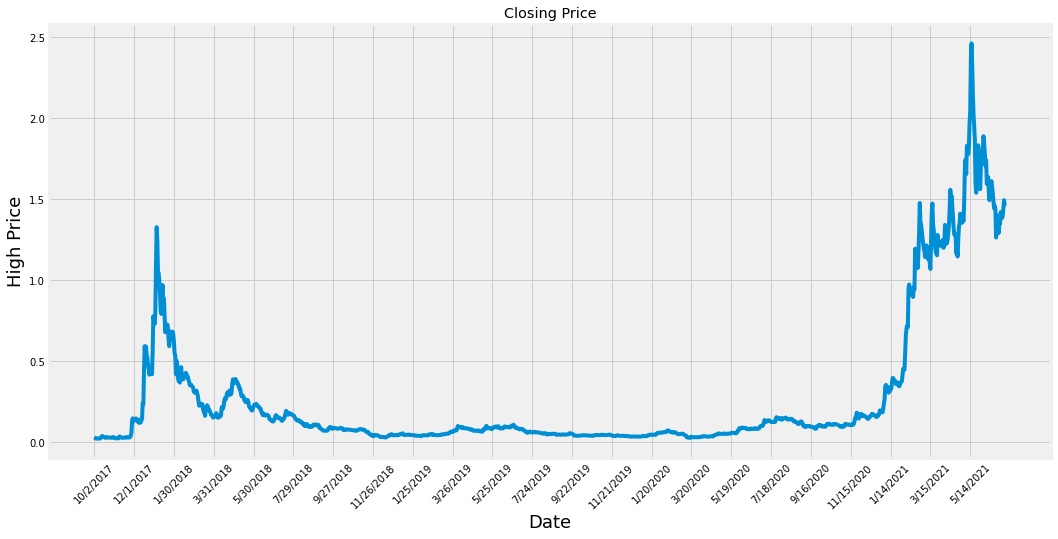

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Closing Price')
plt.plot(df['High'])
plt.xticks(range(0,df.shape[0],60),df['Date'].loc[::60],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price', fontsize=18)

In [ ]:
# ดึงเฉพาะราคาสูงสุดมา
data = df.filter(['High'])

#แปลงข้อมูลใน data ให้เป็น Numpy array
dataset = data.values

#แบ่งข้อมูลแบบ train 80, test 20
training_data_len = math.ceil(len(dataset) * 0.8)
#ดูว่า train 80% มีขนาดเท่าไร
training_data_len

1100

In [ ]:
# ปรับ Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# เลือก 80 % จาก scaled_data
train_data = scaled_data[:training_data_len, :]

x_train = [] 
y_train = []

# เลือกข้อมูลมา 60วัน(x_train) เพือทำนายวันถัดไป(y_train)
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
#จากนั้นแปลงกับให้เป็น Numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))


In [ ]:
# init model ขึ้นมาโดยใช้ LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
# ทำการ Train model
history = model.fit(x_train, y_train,  epochs=1,batch_size=1)
#Dmodel.save("lstmCanano3")


1040/1040 [==============================] - 33s 29ms/step - loss: 0.1554 - accuracy: 0.0000e+00


In [ ]:
history = model.load_weights('/content/drive/MyDrive/lstmCanano3')

In [ ]:
test_data = scaled_data[training_data_len - 60: , :] 

x_test = [] 
y_test = dataset[training_data_len: :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# ทำนาย model 
predictions = model.predict(x_test)

# transform scaler กลับเป็นค่าเดิม
predictions = scaler.inverse_transform(predictions)

In [ ]:
# ใช้ metrics แบบ root mean squared error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.041804650114469516

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


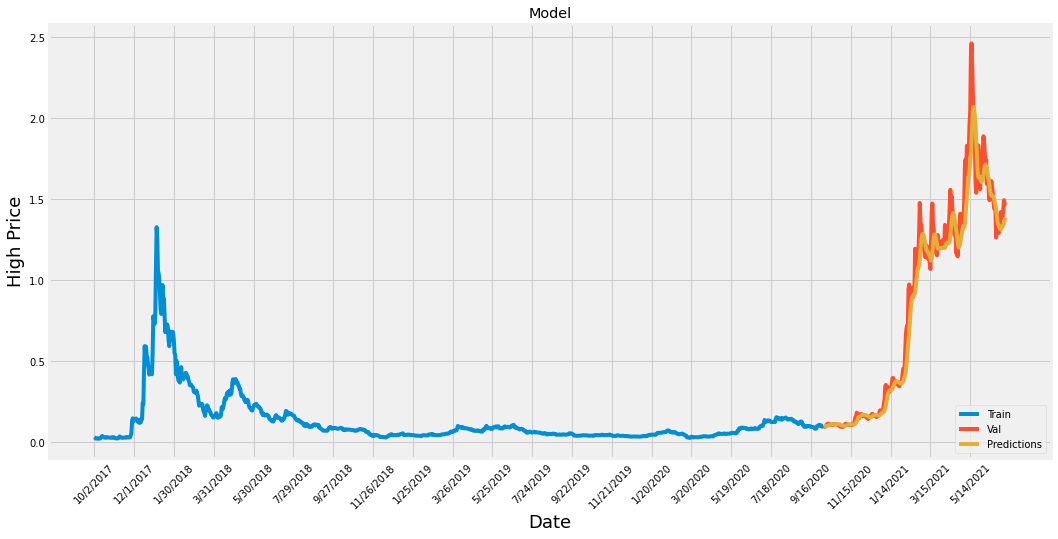

In [ ]:
# plot ค่าจริงกับค่าที่ทำนายไว้มาดู
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid['Date'] = df['Date']


plt.figure(figsize=(16,8))
plt.title('Model')
plt.xticks(range(0,df.shape[0],60),df['Date'].loc[::60],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price', fontsize=18)
plt.plot(train['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'] , loc='lower right')
plt.show()

In [ ]:
valid

,High,Predictions,Date
1100,0.098498,0.101125,10/6/2020
1101,0.094325,0.100795,10/7/2020
1102,0.096698,0.100069,10/8/2020
1103,0.102475,0.099522,10/9/2020
1104,0.110540,0.099815,10/10/2020
...,...,...,...
1369,1.394397,1.335428,7/2/2021
1370,1.441714,1.341245,7/3/2021
1371,1.493717,1.352575,7/4/2021
1372,1.461221,1.371690,7/5/2021


In [ ]:
# ดึง data มาอีกรอบเพื่ออ้างอิง
quote = pd.read_csv("/content/drive/MyDrive/coin_Cardano1.csv")

#สร้าง DataFrame มาใหม่
new_df = quote.filter(['High'])

# ดึงราคาสูงสุดจาก 60 วันล่าสุด
last_60_days = new_df[-60:].values

# Scale
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#predicted
pred_price = model.predict(X_test)

#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)



[[1.3970459]]


In [ ]:
quote2 = pd.read_csv("/content/drive/MyDrive/coin_Cardano1.csv")
quote2['High']

0       0.030088
1       0.027425
2       0.022806
3       0.022154
4       0.021542
          ...   
1369    1.394397
1370    1.441714
1371    1.493717
1372    1.461221
1373    1.456887
Name: High, Length: 1374, dtype: float64